In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/dataset/")
!pwd

/content/drive/MyDrive/Colab Notebooks/dataset


In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

#pip install mahotas

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/dataset'
file = os.listdir()
print(file)

['train.csv', 'test.csv', 'test_image', 'train_image', 'train(vaild_label).csv', 'upload_pred.csv']


In [ ]:
valid_data = pd.read_csv(file[4])
valid_data.head()
# valid=1 validing data , valid=0, training data

,Unnamed: 0,ID,Label,valid
0,0,train_00000.png,0,0
1,1,train_00001.png,1,1
2,2,train_00002.png,1,0
3,3,train_00003.png,5,0
4,4,train_00004.png,5,0


In [ ]:
train_pd = valid_data[(valid_data['valid']==0)]
valid_pd = valid_data[(valid_data['valid']==1)]

In [ ]:
# the numbers of label in training data (training data in validation)
unique, counts = np.unique(train_pd['Label'].values, return_counts=True)
print("unique ", unique)
print("counts: ", counts)

unique  [0 1 2 3 4 5]
counts:  [471 344  70 264 168 450]


In [ ]:
train_pd = train_pd.drop('Unnamed: 0', axis=1)
train_pd = train_pd.drop('valid', axis=1)

valid_pd = valid_pd.drop('Unnamed: 0', axis=1)
valid_pd = valid_pd.drop('valid', axis=1)

In [ ]:
#adjust weight
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=unique, y=train_pd['Label'].values)
print(class_weights)

[0.62526539 0.85610465 4.20714286 1.1155303  1.75297619 0.65444444]


In [ ]:
train_image_path = os.path.join(path, file[3])

train_pd.reset_index(drop=True, inplace=True)
valid_pd.reset_index(drop=True, inplace=True)

In [ ]:
x_train = []
for i in range(len(train_pd.loc[:,'ID'])):
  image_data = cv2.imread(os.path.join(train_image_path, train_pd["ID"][i]))
  new_image_data = cv2.resize(image_data, dsize=(512, 512))
  x_train.append(new_image_data)
x_train = np.array(x_train).reshape(-1,512,512,3)

In [ ]:
print(np.array(x_train).shape)

(1767, 512, 512, 3)


In [ ]:
x_valid = []
for i in range(len(valid_pd.loc[:,'ID'])):
  image_data = cv2.imread(os.path.join(train_image_path, valid_pd["ID"][i]))
  new_image_data = cv2.resize(image_data, dsize=(512, 512))
  x_valid.append(new_image_data)
x_valid = np.array(x_valid).reshape(-1,512,512,3)

In [ ]:
print(np.array(x_valid).shape)

(761, 512, 512, 3)


In [ ]:
y_train = list(train_pd['Label'])
y_valid = list(valid_pd['Label'])

# CNN 2-layer + class_weight / epoch 50

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, SpatialDropout2D, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping


import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
from matplotlib.pyplot import cm
from tensorflow.keras.models import Model

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
##CNN架構

## input layer
input_layer = Input((512, 512, 3))

## convolutional layers
conv_layer1 = Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(input_layer)
## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool2D(pool_size=(2, 2))(conv_layer1)

conv_layer2 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(pooling_layer1)
pooling_layer2 = MaxPool2D(pool_size=(2, 2))(conv_layer2)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer4 = BatchNormalization()(pooling_layer2)
flatten_layer = Flatten()(pooling_layer4)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=512, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
output_layer = Dense(units=6, activation='sigmoid')(dense_layer1)

## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 510, 510, 8)       224       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 255, 255, 8)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 253, 253, 16)      1168      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 126, 126, 16)     0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 126, 126, 16)     64  

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(loss='sparse_categorical_crossentropy',
          optimizer= "adam",
          metrics=['acc'])

In [ ]:
## CNN model fitting
history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=50, validation_split=0.2, class_weight=class_weights)

Train on 1413 samples, validate on 354 samples
Epoch 1/50
1413/1413 [==============================] - ETA: 0s - loss: 68.6763 - acc: 0.6086

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1413/1413 [==============================] - 12s 8ms/sample - loss: 68.6763 - acc: 0.6086 - val_loss: 1590.7228 - val_acc: 0.1751
Epoch 2/50
1413/1413 [==============================] - 11s 8ms/sample - loss: 14.8741 - acc: 0.8117 - val_loss: 477.5121 - val_acc: 0.2571
Epoch 3/50
1413/1413 [==============================] - 11s 8ms/sample - loss: 6.3782 - acc: 0.8938 - val_loss: 179.8030 - val_acc: 0.4746
Epoch 4/50
1413/1413 [==============================] - 11s 8ms/sample - loss: 5.0430 - acc: 0.9073 - val_loss: 36.8965 - val_acc: 0.6271
Epoch 5/50
1413/1413 [==============================] - 11s 8ms/sample - loss: 1.9601 - acc: 0.9540 - val_loss: 175.0595 - val_acc: 0.3079
Epoch 6/50
1413/1413 [==============================] - 11s 8ms/sample - loss: 2.6981 - acc: 0.9462 - val_loss: 72.2071 - val_acc: 0.6271
Epoch 7/50
1413/1413 [==============================] - 11s 8ms/sample - loss: 1.3096 - acc: 0.9653 - val_loss: 46.9851 - val_acc: 0.6186
Epoch 8/50
1413/1413 [================

In [ ]:
pred = model.predict(x_valid)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


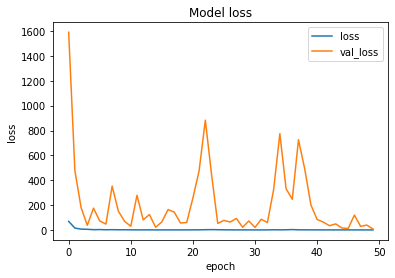

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

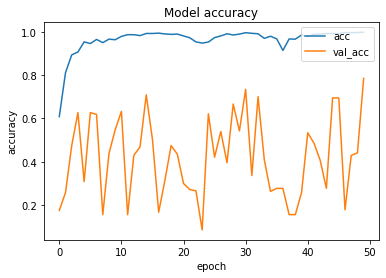

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper right')
plt.show()

In [ ]:
valid_pred = list(np.argmax(pred, axis=1))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

acc=round(accuracy_score(y_valid, valid_pred), 3)
print(acc)

0.544


In [ ]:
cm=confusion_matrix(y_valid, valid_pred)
print(cm)

[[203   0   0   0   0   0]
 [ 82  64   0   0   1   1]
 [ 26   1   3   0   0   0]
 [113   1   0   0   0   0]
 [ 22  18   5  10  17   0]
 [ 65   0   0   0   2 127]]


In [ ]:
unique_pred, counts_pred = np.unique(valid_pred, return_counts=True)
print("unique ", unique_pred)
print("counts: ", counts_pred)

unique  [0 1 2 3 4 5]
counts:  [511  84   8  10  20 128]


# CNN 3 layer + class wieght / epoch 70

In [ ]:
##CNN架構

## input layer
input_layer = Input((512, 512, 3))

## convolutional layers
conv_layer1 = Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(input_layer)
## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool2D(pool_size=(2, 2))(conv_layer1)

conv_layer2 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(pooling_layer1)
pooling_layer2 = MaxPool2D(pool_size=(2, 2))(conv_layer2)

conv_layer3 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(pooling_layer2)
pooling_layer3 = MaxPool2D(pool_size=(2, 2))(conv_layer3)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer4 = BatchNormalization()(pooling_layer3)
flatten_layer = Flatten()(pooling_layer4)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=512, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
output_layer = Dense(units=6, activation='softmax')(dense_layer1)

## define the model with input layer and output layer
model2 = Model(inputs=input_layer, outputs=output_layer)
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 510, 510, 8)       224       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 255, 255, 8)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 253, 253, 16)      1168      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 126, 126, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 124, 124, 32)      4640

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model2.compile(loss='sparse_categorical_crossentropy',
          optimizer= "adam",
          metrics=['acc'])

In [ ]:
## CNN model fitting
history2 = model2.fit(x=x_train, y=y_train, batch_size=32, epochs=70, validation_split=0.2, class_weight=class_weights)

Train on 1413 samples, validate on 354 samples
Epoch 1/70
1413/1413 [==============================] - ETA: 0s - loss: 22.4496 - acc: 0.5690

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1413/1413 [==============================] - 12s 8ms/sample - loss: 22.4496 - acc: 0.5690 - val_loss: 576.8206 - val_acc: 0.2627
Epoch 2/70
1413/1413 [==============================] - 11s 7ms/sample - loss: 3.2348 - acc: 0.8040 - val_loss: 180.7172 - val_acc: 0.3898
Epoch 3/70
1413/1413 [==============================] - 10s 7ms/sample - loss: 0.8242 - acc: 0.8924 - val_loss: 167.9678 - val_acc: 0.3051
Epoch 4/70
1413/1413 [==============================] - 11s 7ms/sample - loss: 0.6670 - acc: 0.9186 - val_loss: 61.2932 - val_acc: 0.2627
Epoch 5/70
1413/1413 [==============================] - 11s 7ms/sample - loss: 0.5266 - acc: 0.9314 - val_loss: 48.3764 - val_acc: 0.3983
Epoch 6/70
1413/1413 [==============================] - 11s 7ms/sample - loss: 0.1946 - acc: 0.9632 - val_loss: 7.7809 - val_acc: 0.5876
Epoch 7/70
1413/1413 [==============================] - 11s 7ms/sample - loss: 0.0959 - acc: 0.9759 - val_loss: 59.9611 - val_acc: 0.1723
Epoch 8/70
1413/1413 [====================

In [ ]:
pred2 = model2.predict(x_valid)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


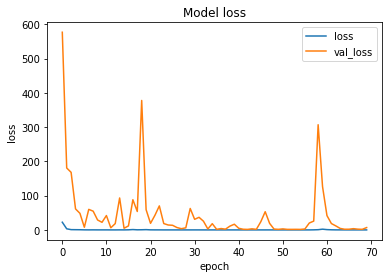

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

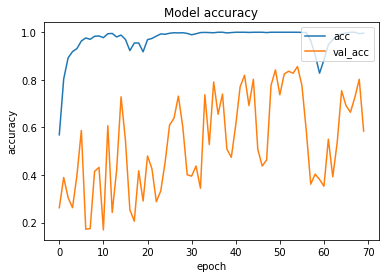

In [ ]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper right')
plt.show()

In [ ]:
valid_pred_2 = list(np.argmax(pred2, axis=1))

In [ ]:
acc2=round(accuracy_score(y_valid, valid_pred_2), 4)
print(acc2)

0.5953


In [ ]:
cm2=confusion_matrix(y_valid, valid_pred_2)
print(cm2)

[[ 90 112   0   0   0   1]
 [  6 131   0   2   3   6]
 [  0  30   0   0   0   0]
 [ 48  52   2   6   5   1]
 [  2  23   6   4  35   2]
 [  0   3   0   0   0 191]]


In [ ]:
unique_pred_2, counts_pred_2 = np.unique(valid_pred_2, return_counts=True)
print("unique ", unique_pred_2)
print("counts: ", counts_pred_2)

unique  [0 1 2 3 4 5]
counts:  [146 351   8  12  43 201]


# CNN 3 layer + class wieght / epoch 60

In [ ]:
##CNN架構

## input layer
input_layer = Input((512, 512, 3))

## convolutional layers
conv_layer1 = Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(input_layer)
## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool2D(pool_size=(2, 2))(conv_layer1)

conv_layer2 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(pooling_layer1)
pooling_layer2 = MaxPool2D(pool_size=(2, 2))(conv_layer2)

conv_layer3 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(pooling_layer2)
pooling_layer3 = MaxPool2D(pool_size=(2, 2))(conv_layer3)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer4 = BatchNormalization()(pooling_layer3)
flatten_layer = Flatten()(pooling_layer4)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=512, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
output_layer = Dense(units=6, activation='softmax')(dense_layer1)

## define the model with input layer and output layer
model3 = Model(inputs=input_layer, outputs=output_layer)
model3.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 510, 510, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 16)     0         
 2D)                                                             
                                                       

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model3.compile(loss='sparse_categorical_crossentropy',
          optimizer= "adam",
          metrics=['acc'])

In [ ]:
## CNN model fitting
history3 = model3.fit(x=x_train, y=y_train, batch_size=32, epochs=60, validation_split=0.2, class_weight=class_weights)

Train on 1413 samples, validate on 354 samples
Epoch 1/60
1413/1413 [==============================] - ETA: 0s - loss: 30.1734 - acc: 0.5938

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1413/1413 [==============================] - 25s 18ms/sample - loss: 30.1734 - acc: 0.5938 - val_loss: 837.0128 - val_acc: 0.3079
Epoch 2/60
1413/1413 [==============================] - 12s 8ms/sample - loss: 7.1628 - acc: 0.8167 - val_loss: 498.9096 - val_acc: 0.1723
Epoch 3/60
1413/1413 [==============================] - 12s 8ms/sample - loss: 1.7223 - acc: 0.8776 - val_loss: 349.1792 - val_acc: 0.2768
Epoch 4/60
1413/1413 [==============================] - 12s 9ms/sample - loss: 0.6753 - acc: 0.9278 - val_loss: 296.8354 - val_acc: 0.2627
Epoch 5/60
1413/1413 [==============================] - 13s 10ms/sample - loss: 0.5151 - acc: 0.9505 - val_loss: 182.2420 - val_acc: 0.3503
Epoch 6/60
1413/1413 [==============================] - 12s 8ms/sample - loss: 0.2926 - acc: 0.9625 - val_loss: 159.7049 - val_acc: 0.2627
Epoch 7/60
1413/1413 [==============================] - 12s 8ms/sample - loss: 0.1982 - acc: 0.9738 - val_loss: 150.2023 - val_acc: 0.2712
Epoch 8/60
1413/1413 [=============

In [ ]:
pred3 = model3.predict(x_valid)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


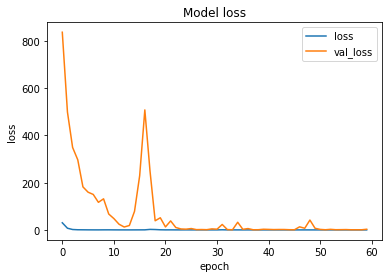

In [ ]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

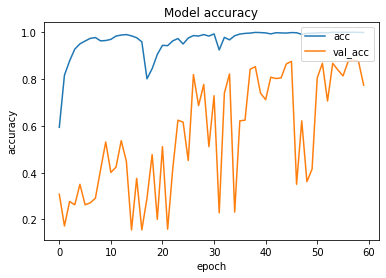

In [ ]:
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper right')
plt.show()

In [ ]:
valid_pred_3 = list(np.argmax(pred3, axis=1))

In [ ]:
acc3=round(accuracy_score(y_valid, valid_pred_3), 4)
print(acc3)

0.7398


In [ ]:
cm3=confusion_matrix(y_valid, valid_pred_3)
print(cm3)

[[147  35   3   2   0  16]
 [  3 128   0   4   2  11]
 [  1  28   1   0   0   0]
 [ 38  30   2  36   5   3]
 [  0   2   0   4  57   9]
 [  0   0   0   0   0 194]]


In [ ]:
unique_pred_3, counts_pred_3 = np.unique(valid_pred_3, return_counts=True)
print("unique ", unique_pred_3)
print("counts: ", counts_pred_3)

unique  [0 1 2 3 4 5]
counts:  [189 223   6  46  64 233]


# CNN 3 layer + class wieght / epoch 70

In [ ]:
##CNN架構

## input layer
input_layer = Input((512, 512, 3))

## convolutional layers
conv_layer1 = Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(input_layer)
## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool2D(pool_size=(2, 2))(conv_layer1)

conv_layer2 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(pooling_layer1)
pooling_layer2 = MaxPool2D(pool_size=(2, 2))(conv_layer2)

conv_layer3 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(pooling_layer2)
pooling_layer3 = MaxPool2D(pool_size=(2, 2))(conv_layer3)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer4 = BatchNormalization()(pooling_layer3)
flatten_layer = Flatten()(pooling_layer4)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=512, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
output_layer = Dense(units=6, activation='softmax')(dense_layer1)

## define the model with input layer and output layer
model4 = Model(inputs=input_layer, outputs=output_layer)
model4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 510, 510, 8)       224       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 255, 255, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 253, 253, 16)      1168      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 126, 126, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 124, 124, 32)      4640

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model4.compile(loss='sparse_categorical_crossentropy',
          optimizer= "adam",
          metrics=['acc'])

In [ ]:
## CNN model fitting
history4 = model4.fit(x=x_train, y=y_train, batch_size=32, epochs=70, validation_split=0.2, class_weight=class_weights)

Train on 1413 samples, validate on 354 samples
Epoch 1/70
1413/1413 [==============================] - ETA: 0s - loss: 24.2197 - acc: 0.6575

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1413/1413 [==============================] - 11s 8ms/sample - loss: 24.2197 - acc: 0.6575 - val_loss: 508.0612 - val_acc: 0.2966
Epoch 2/70
1413/1413 [==============================] - 11s 8ms/sample - loss: 5.6595 - acc: 0.8224 - val_loss: 230.7110 - val_acc: 0.2203
Epoch 3/70
1413/1413 [==============================] - 11s 8ms/sample - loss: 1.9868 - acc: 0.8698 - val_loss: 88.8888 - val_acc: 0.5028
Epoch 4/70
1413/1413 [==============================] - 11s 8ms/sample - loss: 0.9639 - acc: 0.9172 - val_loss: 81.8337 - val_acc: 0.4774
Epoch 5/70
1413/1413 [==============================] - 11s 8ms/sample - loss: 0.8522 - acc: 0.9285 - val_loss: 291.6968 - val_acc: 0.1723
Epoch 6/70
1413/1413 [==============================] - 11s 8ms/sample - loss: 0.8354 - acc: 0.9200 - val_loss: 67.2068 - val_acc: 0.3955
Epoch 7/70
1413/1413 [==============================] - 11s 8ms/sample - loss: 0.7095 - acc: 0.9144 - val_loss: 45.5337 - val_acc: 0.5876
Epoch 8/70
1413/1413 [===================

In [ ]:
pred4 = model4.predict(x_valid)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


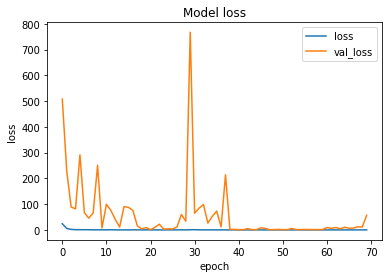

In [ ]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

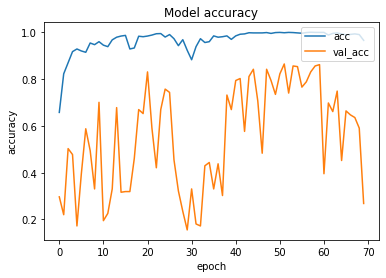

In [ ]:
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper right')
plt.show()

In [ ]:
valid_pred_4 = list(np.argmax(pred4, axis=1))

In [ ]:
acc4=round(accuracy_score(y_valid, valid_pred_4), 4)
print(acc4)

0.2615


In [ ]:
cm4=confusion_matrix(y_valid, valid_pred_4)
print(cm4)

[[  2 106   0  95   0   0]
 [  3 135   0  10   0   0]
 [  0  19   0  11   0   0]
 [  0  52   0  62   0   0]
 [  0  58   0  14   0   0]
 [  4 187   0   3   0   0]]


In [ ]:
unique_pred_4, counts_pred_4 = np.unique(valid_pred_4, return_counts=True)
print("unique ", unique_pred_4)
print("counts: ", counts_pred_4)

unique  [0 1 3]
counts:  [  9 557 195]


# CNN 3 layer + class wieght / change dim_output

In [ ]:
##CNN架構
## convolutional layers
conv_layer1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(input_layer)
## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool2D(pool_size=(2, 2))(conv_layer1)

conv_layer2 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(pooling_layer1)
pooling_layer2 = MaxPool2D(pool_size=(2, 2))(conv_layer2)

conv_layer3 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(pooling_layer2)
pooling_layer3 = MaxPool2D(pool_size=(2, 2))(conv_layer3)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer4 = BatchNormalization()(pooling_layer3)
flatten_layer = Flatten()(pooling_layer4)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=512, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
output_layer = Dense(units=6, activation='softmax')(dense_layer1)

## define the model with input layer and output layer
model5 = Model(inputs=input_layer, outputs=output_layer)
model5.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 255, 255, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 124, 124, 128)     7385

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model5.compile(loss='sparse_categorical_crossentropy',
          optimizer= "adam",
          metrics=['acc'])

In [ ]:
## CNN model fitting
history5 = model5.fit(x=x_train, y=y_train, batch_size=32, epochs=60, validation_split=0.2, class_weight=class_weights)

Train on 1413 samples, validate on 354 samples
Epoch 1/60
1413/1413 [==============================] - ETA: 0s - loss: 78.8006 - acc: 0.5895

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1413/1413 [==============================] - 44s 31ms/sample - loss: 78.8006 - acc: 0.5895 - val_loss: 3694.7382 - val_acc: 0.1554
Epoch 2/60
1413/1413 [==============================] - 28s 20ms/sample - loss: 31.8028 - acc: 0.7424 - val_loss: 2057.7621 - val_acc: 0.4011
Epoch 3/60
1413/1413 [==============================] - 28s 20ms/sample - loss: 11.1655 - acc: 0.7948 - val_loss: 1765.0032 - val_acc: 0.1723
Epoch 4/60
1413/1413 [==============================] - 28s 20ms/sample - loss: 8.6056 - acc: 0.8096 - val_loss: 2103.7251 - val_acc: 0.1554
Epoch 5/60
1413/1413 [==============================] - 28s 20ms/sample - loss: 8.1329 - acc: 0.7849 - val_loss: 3874.9614 - val_acc: 0.1554
Epoch 6/60
1413/1413 [==============================] - 29s 20ms/sample - loss: 5.8459 - acc: 0.8351 - val_loss: 1884.8228 - val_acc: 0.1554
Epoch 7/60
1413/1413 [==============================] - 28s 20ms/sample - loss: 2.9519 - acc: 0.8117 - val_loss: 1772.4185 - val_acc: 0.1554
Epoch 8/60
1413/1413 

In [ ]:
pred5 = model5.predict(x_valid)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


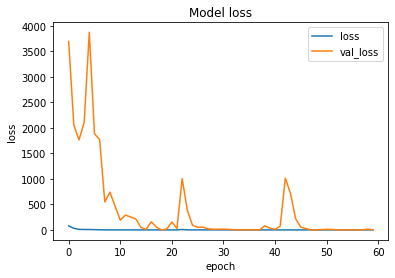

In [ ]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

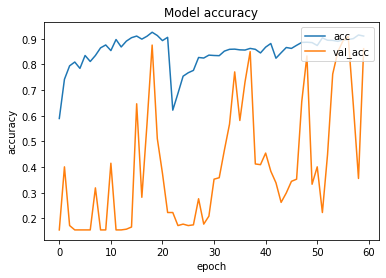

In [ ]:
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper right')
plt.show()

In [ ]:
valid_pred_5 = list(np.argmax(pred5, axis=1))

In [ ]:
acc5=round(accuracy_score(y_valid, valid_pred_5), 4)
print(acc5)

0.8305


In [ ]:
cm5=confusion_matrix(y_valid, valid_pred_5)
print(cm5)

[[158   0   1  44   0   0]
 [  2 110   4  29   2   1]
 [  0   0  26   4   0   0]
 [ 13   0   0  99   2   0]
 [  0   0   0  16  56   0]
 [  8   3   0   0   0 183]]


In [ ]:
unique_pred_5, counts_pred_5 = np.unique(valid_pred_5, return_counts=True)
print("unique ", unique_pred_5)
print("counts: ", counts_pred_5)

unique  [0 1 2 3 4 5]
counts:  [181 113  31 192  60 184]


In [ ]:
model5.predict_proba()

In [ ]:
def get_pr(pos_prob,y_true):
    pos = y_true[y_true==1]
    threshold = np.sort(pos_prob)[::-1]
    y = y_true[pos_prob.argsort()[::-1]]
    recall = [] ; precision = []
    tp = 0 ; fp = 0
    auc = 0
    for i in range(len(threshold)):
        if y[i] == 1:
            tp += 1
            recall.append(tp/len(pos))
            precision.append(tp/(tp+fp))
            auc += (recall[i]-recall[i-1])*precision[i]
        else:
            fp += 1
            recall.append(tp/len(pos))
            precision.append(tp/(tp+fp))
    return precision,recall,auc

In [ ]:
precision_mod5,recall_mod5,auc_mod5 = get_pr(np.array(valid_pred_5),np.array(y_valid))

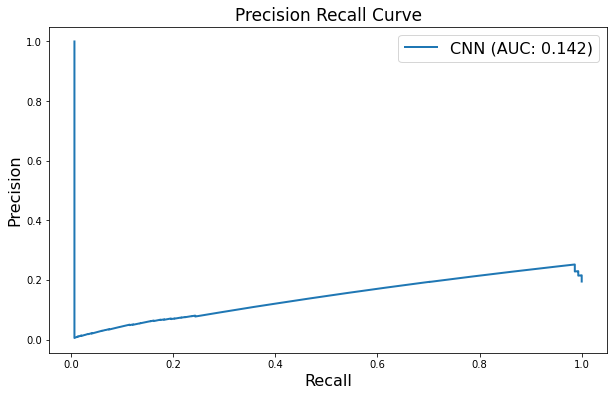

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(recall_mod5,precision_mod5,label="CNN (AUC: {:.3f})".format(auc_mod5),linewidth=2)
plt.xlabel("Recall",fontsize=16)
plt.ylabel("Precision",fontsize=16)
plt.title("Precision Recall Curve",fontsize=17)
plt.legend(fontsize=16)

In [ ]:
# create y testing data
test_image_path = os.path.join(path, file[2])
test_pd = pd.read_csv(file[1])
print(test_pd.shape)
test_pd.head()

(10142, 2)


,ID,Label
0,test_00000.png,NaN
1,test_00001.png,NaN
2,test_00002.png,NaN
3,test_00003.png,NaN
4,test_00004.png,NaN


In [ ]:
x_test = []
for i in range(9000,10142):
  image_data = cv2.imread(os.path.join(test_image_path, test_pd["ID"][i]))
  new_image_data = cv2.resize(image_data, dsize=(512, 512))
  x_test.append(new_image_data)
x_test = np.array(x_test).reshape(-1,512,512,3)

In [ ]:
# predict the testing data
test_pred = model5.predict(x_test)
upload_pred = list(np.argmax(test_pred, axis=1))

test_pd['Label'][9000:10142] = upload_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
test_pd['Label'] = test_pd['Label'].astype('int')

In [ ]:
test_pd.to_csv('upload_pred2.csv', index=False)